# Проект по курсу DS-prof-2022-08 OTUS на тему

## Прогнозирование вероятности наступления целевого события на трубопроводах ресурсоснабжающий организации

# План проекта
1. Подготовить данные для EDA
2. Провести EDA
3. По результатам EDA провести дополнительные преобразования
4. Моделирование
5. Обработка результатов
6. Вывод

# Импорты

In [1]:
import os
import glob
import pathlib
from pathlib import Path

import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import catboost
from catboost import CatBoostClassifier
#from catboost import Pool

C:\Users\smndy\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# EDA. Очистка данных, подготовка дата-фрейма для моделирования

## Подгтовка к EDA

In [2]:
#каталог с дата-фреймами
dir_tabl = r'C:\Users\smndy\Documents\skillfactory\OTUS DS\Проект\data'

In [3]:
#функция для получения имен листов
def get_name_sheets_excel(dir_tabl, file_xlsx):
    path_file_xlsx_open = Path(dir_tabl, file_xlsx)
    xls = pd.ExcelFile(path_file_xlsx_open)
    name_sheets_excel = xls.sheet_names
    return print(name_sheets_excel)

#функция записи ексель таблицы в дата-фрейм
def open_name_sheets_excel(dir_tabl, file_xlsx, name_sheets):
    path_file_xlsx_open = Path(dir_tabl, file_xlsx)
    xls = pd.ExcelFile(path_file_xlsx_open)
    data = xls.parse('Sheet1')
    return data

In [4]:
file_xlsx = r'df_seti.xlsx'
get_name_sheets_excel(dir_tabl = dir_tabl, file_xlsx = file_xlsx)

['Sheet1']


In [5]:
data = open_name_sheets_excel(dir_tabl = dir_tabl, file_xlsx = file_xlsx,  name_sheets = 'Sheet1')
df_seti = data.copy()

In [6]:
df_seti.head(3)

,Unnamed: 0,Код,Инвентарный номер,Наименование,Наименование вида объекта,Наименование района,Наименование подразделения,Дата ввода в эксплуатацию,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм."
0,234,03200_102_б/х,102_б/х,"Сеть холодного водоснабжения от ВК-1 (сущ) у ж.д. № 8, 10 по ул. Чистопольской до ВК-2 (сущ) около ЦТП №42",Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,36.86,100.0
1,243,03200_100_б/х,100_б/х,Сети холодного водоснабжения по ул. Новоржевская от ул. Ардатовская до ул. Б. Хмельницкого,Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,сталь,На обслуживании,755.00,200.0
2,245,03200_98_б/х,98_б/х,"Автозаводская,4 ввод на ЦТП-41",Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,202.80,200.0


In [7]:
df_seti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6117 entries, 0 to 6116
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             6117 non-null   int64  
 1   Код                                    6117 non-null   object 
 2   Инвентарный номер                      6117 non-null   object 
 3   Наименование                           6117 non-null   object 
 4   Наименование вида объекта              6117 non-null   object 
 5   Наименование района                    6117 non-null   object 
 6   Наименование подразделения             6117 non-null   object 
 7   Дата ввода в эксплуатацию              6117 non-null   object 
 8   Наименование материала                 6117 non-null   object 
 9   Наименование принадлежности имущества  6117 non-null   object 
 10  Длина, пог.м.                          6117 non-null   float64
 11  Диам

In [8]:
df_seti.columns

Index(['Unnamed: 0', 'Код ', 'Инвентарный номер', 'Наименование',
       'Наименование вида объекта', 'Наименование района',
       'Наименование подразделения', 'Дата ввода в эксплуатацию',
       'Наименование материала', 'Наименование принадлежности имущества',
       'Длина, пог.м.', 'Диаметр, мм.'],
      dtype='object')

In [9]:
file_xlsx = r'df_target_sobitiya.xlsx'
get_name_sheets_excel(dir_tabl = dir_tabl, file_xlsx = file_xlsx)

['Sheet1']


In [10]:
data = open_name_sheets_excel(dir_tabl = dir_tabl, file_xlsx = file_xlsx,  name_sheets = 'Sheet1')
df_target_sobitiya = data.copy()

In [11]:
df_target_sobitiya.head(3)

,Unnamed: 0,Дата и время регистрации [заявки],Дата и время создания [заявки],"Длительность, ч [заявки]",Номер [заявки],Объект [заявки],Проявление [заявки],Тип системы [заявки],Номер,date_time_x,...,Инвентарный номер,Наименование,Наименование вида объекта,Наименование района,Наименование подразделения,Дата ввода в эксплуатацию,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм."
0,0,2018-03-21 00:00:00,2018-03-21 00:00:00,49.209167,226184,Сети водопровода ведомственные без объекта (04208),Утечка из земли,Водоснабжение,226184,2018-03-21 15:00:00,...,04208_ведомственные,Сети водопровода ведомственные без объекта (04208),Трубопровод напорный,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,01.01.1950,чугун,Ведомственное,54.98,100.0
1,1,2018-01-02 00:00:00,2018-01-02 00:00:00,189.864722,218618,Сети водопровода ведомственные без объекта (03200),Утечка из земли,Водоснабжение,218618,2018-01-02 16:00:00,...,03200_ведомственные,Сети водопровода ведомственные без объекта (03200),Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1950,чугун,Ведомственное,54.98,100.0
2,2,2018-01-02 00:00:00,2018-01-02 00:00:00,11.211944,218631,Сети водопровода ведомственные без объекта (04208),Утечка из земли,Водоснабжение,218631,2018-01-02 19:00:00,...,04208_ведомственные,Сети водопровода ведомственные без объекта (04208),Трубопровод напорный,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,01.01.1950,чугун,Ведомственное,54.98,100.0


In [12]:
df_target_sobitiya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9152 entries, 0 to 9151
Data columns (total 42 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Unnamed: 0                             9152 non-null   int64         
 1   Дата и время регистрации [заявки]      9152 non-null   object        
 2   Дата и время создания [заявки]         9152 non-null   object        
 3   Длительность, ч [заявки]               9114 non-null   float64       
 4   Номер [заявки]                         9152 non-null   int64         
 5   Объект [заявки]                        9152 non-null   object        
 6   Проявление [заявки]                    9152 non-null   object        
 7   Тип системы [заявки]                   9152 non-null   object        
 8   Номер                                  9152 non-null   int64         
 9   date_time_x                            9152 non-null   datetime

In [13]:
df_target_sobitiya.columns

Index(['Unnamed: 0', 'Дата и время регистрации [заявки]',
       'Дата и время создания [заявки]', 'Длительность, ч [заявки]',
       'Номер [заявки]', 'Объект [заявки]', 'Проявление [заявки]',
       'Тип системы [заявки]', 'Номер', 'date_time_x',
       'Дата и время регистрации', 'date_time_range', 'date_time_y', 'T', 'Po',
       'Pa', 'U', 'N', 'W1', 'W2', 'VV', 'Td', 'E'', 'sss', 'year', 'date',
       'month', 'N_code', 'W1_code', 'W2_code', 'sss_code', 'Код ',
       'Инвентарный номер', 'Наименование', 'Наименование вида объекта',
       'Наименование района', 'Наименование подразделения',
       'Дата ввода в эксплуатацию', 'Наименование материала',
       'Наименование принадлежности имущества', 'Длина, пог.м.',
       'Диаметр, мм.'],
      dtype='object')

In [14]:
df_target_sobitiya.shape

(9152, 42)

In [15]:
df_target_sobitiya_columns = ['Номер', 'Объект [заявки]']
df_target_sobitiya[df_target_sobitiya_columns]

,Номер,Объект [заявки]
0,226184,Сети водопровода ведомственные без объекта (04208)
1,218618,Сети водопровода ведомственные без объекта (03200)
2,218631,Сети водопровода ведомственные без объекта (04208)
3,218654,Сети водопровода бесхозные без объекта (03200)
4,218658,Сети водопровода бесхозные без объекта (03200)
...,...,...
9147,412221,Сети водопровода ведомственные без объекта (04206)
9148,412231,"по Гашкова41 на ЦТП-4от В-2доВКдома33 d200,l156 (5057ч_к)"
9149,412235,Сети водопровода бесхозные без объекта (04208)
9150,412236,"по Сысольская 8а ЦТП d150,l155.9"


In [16]:
df_seti_s_sobitiyami = df_seti.merge(df_target_sobitiya[df_target_sobitiya_columns], 
              how = 'left', left_on = 'Наименование', right_on = 'Объект [заявки]')

In [17]:
df_seti_s_sobitiyami = df_seti_s_sobitiyami.drop(columns = ['Unnamed: 0', 'Объект [заявки]', 'Наименование'])

In [18]:
df_seti_s_sobitiyami_groupby = df_seti_s_sobitiyami.groupby('Код ')[['Номер']].count()

In [19]:
df_seti_s_sobitiyami_groupby = df_seti_s_sobitiyami_groupby.reset_index()

In [20]:
df_seti_s_sobitiyami_groupby

,Код,Номер
0,000005_к,0
1,000006_к,0
2,000007_к,1
3,000009_к,2
4,000043_к,0
...,...,...
6112,ФГБУ ЦЖКУ 04208_вед,0
6113,ЦО-00001076,0
6114,ЦО-00001078,0
6115,Энерг пр 04201_вед,0


In [21]:
df_seti_count_sobitiya = df_seti.merge(df_seti_s_sobitiyami_groupby, how = 'left', on = 'Код ')

In [22]:
df_seti_count_sobitiya = df_seti_count_sobitiya.drop(columns = 'Unnamed: 0')

array([[<AxesSubplot:title={'center':'Длина, пог.м.'}>,
        <AxesSubplot:title={'center':'Диаметр, мм.'}>],
       [<AxesSubplot:title={'center':'Номер'}>, <AxesSubplot:>]],
      dtype=object)

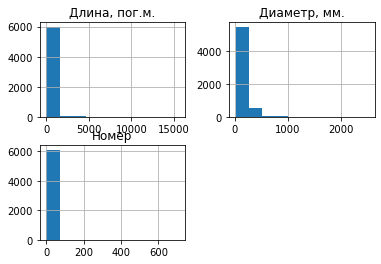

In [23]:
df_seti_count_sobitiya.hist()

In [24]:
df_seti_count_sobitiya[df_seti_count_sobitiya['Номер'] > 0]['Номер'].value_counts(dropna=False, sort=True, ascending=False)

1      809
2      356
3      174
4      117
5       74
6       45
8       28
10      26
9       24
7       22
11      14
14       9
12       8
13       7
16       6
15       4
21       4
18       3
30       2
17       2
33       2
64       2
39       1
35       1
28       1
46       1
19       1
24       1
75       1
447      1
26       1
159      1
54       1
708      1
226      1
25       1
360      1
23       1
500      1
58       1
545      1
38       1
29       1
93       1
430      1
48       1
41       1
22       1
Name: Номер, dtype: int64

### Номер > 356 - 9 Номер > 174 - 8 Номер > 74 - 7 Номер > 28 - 6 Номер > 14 - 5 Номер > 9 - 4 Номер > 3 - 3 Номер > 0 - 2 Номер = 0 - 1

In [25]:
df_seti_count_sobitiya['target'] = ''

In [26]:
df_seti_count_sobitiya.loc[df_seti_count_sobitiya['Номер'] > 356, 'target'] = 8
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 174) & (df_seti_count_sobitiya['Номер'] <= 356), 'target'] = 7
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 74) & (df_seti_count_sobitiya['Номер'] <= 174), 'target'] = 6
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 28) & (df_seti_count_sobitiya['Номер'] <= 74), 'target'] = 5
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 14) & (df_seti_count_sobitiya['Номер'] <= 28), 'target'] = 4
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 9) & (df_seti_count_sobitiya['Номер'] <= 14), 'target'] = 3
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 3) & (df_seti_count_sobitiya['Номер'] <= 9), 'target'] = 2
df_seti_count_sobitiya.loc[(df_seti_count_sobitiya['Номер'] > 0) & (df_seti_count_sobitiya['Номер'] <= 3), 'target'] = 1
df_seti_count_sobitiya.loc[df_seti_count_sobitiya['Номер'] == 0, 'target'] = 0

In [27]:
df_seti_count_sobitiya['target'].value_counts(dropna=False, sort=True, ascending=False)

0    4353
1    1339
2     310
3      64
4      26
5      15
8       6
6       3
7       1
Name: target, dtype: int64

### Определю, что все сети с 'target' > 0 - "Плохие" ('target_class' = 1)

In [28]:
df_seti_count_sobitiya['target_class'] = 0

In [29]:
df_seti_count_sobitiya.loc[df_seti_count_sobitiya['target'] > 0, 'target_class'] = 1

<AxesSubplot:>

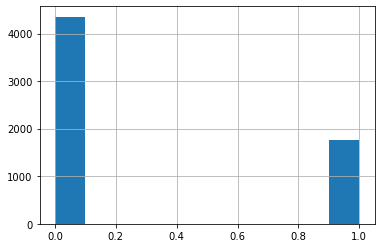

In [30]:
df_seti_count_sobitiya['target_class'].hist()

In [31]:
# процент 
(df_seti_count_sobitiya[df_seti_count_sobitiya['Номер'] > 0]['Номер']
 .value_counts(dropna=False, sort=True, ascending=False)
 .sum())/df_seti_count_sobitiya.shape[0]

0.2883766552231486

## EDA

In [32]:
df_seti_count_sobitiya.head()

,Код,Инвентарный номер,Наименование,Наименование вида объекта,Наименование района,Наименование подразделения,Дата ввода в эксплуатацию,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм.",Номер,target,target_class
0,03200_102_б/х,102_б/х,"Сеть холодного водоснабжения от ВК-1 (сущ) у ж.д. № 8, 10 по ул. Чистопольской до ВК-2 (сущ) около ЦТП №42",Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,36.86,100.0,1,1,1
1,03200_100_б/х,100_б/х,Сети холодного водоснабжения по ул. Новоржевская от ул. Ардатовская до ул. Б. Хмельницкого,Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,сталь,На обслуживании,755.00,200.0,1,1,1
2,03200_98_б/х,98_б/х,"Автозаводская,4 ввод на ЦТП-41",Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,202.80,200.0,1,1,1
3,03200_96_б/х,96_б/х,"Ввод водопровода от существующего колодца по ул. М. Рыбалко до ЦТП-37 (ул. Маршала Рыбалко, 43 ""а"") (М.Рыбалко,43а ввод на ЦТП-37)",Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,198.40,200.0,0,0,0
4,03200_95_б/х,95_б/х,Сеть холодного водоснабжения по ул. Котельнической от ВК-1 у ж.д. №24 до ВК-4 у ж.д.№22 по ул. Воронежской,Трубопровод напорный,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,сталь,На обслуживании,328.26,100.0,0,0,0


In [33]:
df_seti_count_sobitiya.columns

Index(['Код ', 'Инвентарный номер', 'Наименование',
       'Наименование вида объекта', 'Наименование района',
       'Наименование подразделения', 'Дата ввода в эксплуатацию',
       'Наименование материала', 'Наименование принадлежности имущества',
       'Длина, пог.м.', 'Диаметр, мм.', 'Номер', 'target', 'target_class'],
      dtype='object')

In [34]:
df_seti_count_sobitiya.shape

(6117, 14)

In [35]:
df_seti_count_sobitiya.columns

Index(['Код ', 'Инвентарный номер', 'Наименование',
       'Наименование вида объекта', 'Наименование района',
       'Наименование подразделения', 'Дата ввода в эксплуатацию',
       'Наименование материала', 'Наименование принадлежности имущества',
       'Длина, пог.м.', 'Диаметр, мм.', 'Номер', 'target', 'target_class'],
      dtype='object')

### удалю колонки
- 'Код ' = id;
- 'Инвентарный номер' = id;
- 'Наименование' = уникальное имя id;
- 'Наименование вида объекта' - не несет сиысловой нагрузки;
- 'target' - для мультиклассовой классификации в этом проекте не рассматривается такой подход

### колонки для изучения распределений
- 'Номер' - сколько номеров аварийных заявок было за рассматриваемый период, переименую в 'Количество' и удалю на этапе конструирование признаков;
- 'Дата ввода в эксплуатацию' - перевести в срок эксплуатации, в единицах измерения 'год';

In [36]:
drop_list = ['Код ', 'Инвентарный номер', 'Наименование','Наименование вида объекта', 'target']
df_seti_count_sobitiya.drop(columns = drop_list, inplace = True)

#### 'Номер' - сколько номеров аварийных заявок было за рассматриваемый период, переименую в 'Количество' и удалю на этапе конструирование признаков;

In [37]:
df_seti_count_sobitiya.rename(columns = {'Номер': 'Количество'}, inplace=True)

In [38]:
df_seti_count_sobitiya.head(1)

,Наименование района,Наименование подразделения,Дата ввода в эксплуатацию,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм.",Количество,target_class
0,КИРОВСКИЙ,Эксплуатационный участок цех №3,01.01.1970,чугун,На обслуживании,36.86,100.0,1,1


#### 'Дата ввода в эксплуатацию' - перевести в срок эксплуатации, в единицах измерения 'год'. Срок эксплуатации возьму от  'Дата ввода в эксплуатацию' по 31.12.2022 г

In [39]:
#подготовка столбца date
df_temp_date = df_seti_count_sobitiya['Дата ввода в эксплуатацию'].str.split('.', expand = True).rename(columns={0: 'DD', 1: 'MM', 2: 'YYYY'})
df_seti_count_sobitiya = pd.concat([df_seti_count_sobitiya, df_temp_date], axis = 1)
df_seti_count_sobitiya['date'] = pd.to_datetime(df_seti_count_sobitiya['DD'].astype(int).astype(str)+'-'
                            +df_seti_count_sobitiya['MM'].astype(int).astype(str)+'-'
                            +df_seti_count_sobitiya['YYYY'].astype(int).astype(str), format = '%d-%m-%Y').dt.date

df_seti_count_sobitiya['date'] = df_seti_count_sobitiya['date'].astype('datetime64')

#### data_set создаю дата-сет с колонками
 - 'Наименование района', 
 - 'Наименование подразделения', 
 - 'date', 
 - 'Наименование материала', 
 - 'Наименование принадлежности имущества', 
 - 'Длина, пог.м.', 
 - 'Диаметр, мм.', 
 - 'target_class'

In [40]:
data_set = df_seti_count_sobitiya[['Наименование района', 'Наименование подразделения', 
                        'date', 'Наименование материала', 
                        'Наименование принадлежности имущества', 'Длина, пог.м.', 'Диаметр, мм.', 'target_class']].copy()

#### Посчитаю Срок эксплуатации и запишу в колонку data_set['years']

In [41]:
data_set['final_date'] = '2022-12-31'
data_set['final_date'] = data_set['final_date'].astype('datetime64')

In [42]:
data_set['days'] = data_set['final_date'] - data_set['date']

In [43]:
data_set['years'] = data_set['days'].dt.days//365

#### итоговый data_set для EDA

In [44]:
data_set = data_set[['target_class',
                     'Наименование района', 
                     'Наименование подразделения',
                     'Наименование материала', 
                     'Наименование принадлежности имущества',
                     'Длина, пог.м.', 
                     'Диаметр, мм.',  
                     'years']].copy()

In [45]:
data_set.head(1)

,target_class,Наименование района,Наименование подразделения,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм.",years
0,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,чугун,На обслуживании,36.86,100.0,53


#### Посмотрю основные распределения и корреляции использую data_set

In [46]:
#функция для построения histplot с hue
def graf(df, col, col_hue):
    return sns.histplot(data=df, x=df[col], hue=col_hue, multiple="dodge", shrink=0.8) 

In [47]:
data_set.shape

(6117, 8)

In [48]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6117 entries, 0 to 6116
Data columns (total 8 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   target_class                           6117 non-null   int64  
 1   Наименование района                    6117 non-null   object 
 2   Наименование подразделения             6117 non-null   object 
 3   Наименование материала                 6117 non-null   object 
 4   Наименование принадлежности имущества  6117 non-null   object 
 5   Длина, пог.м.                          6117 non-null   float64
 6   Диаметр, мм.                           6117 non-null   float64
 7   years                                  6117 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 430.1+ KB


In [49]:
data_set.dtypes.value_counts()

object     4
int64      2
float64    2
dtype: int64

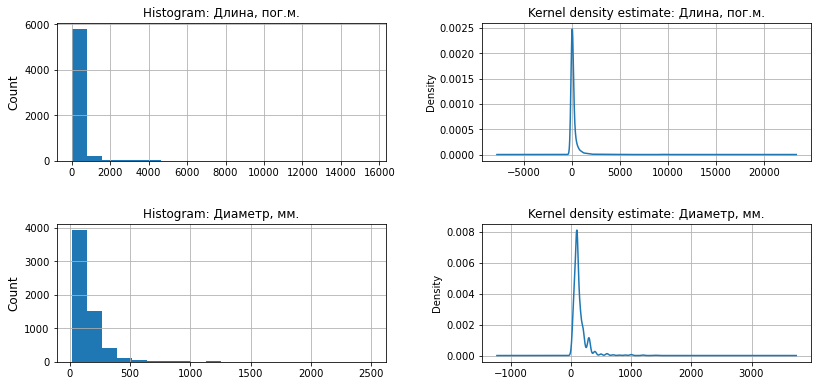

In [50]:
#графики для колонок 'float64'
columns = data_set.select_dtypes(['float64']).columns

fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(12,6))

for index, column in enumerate(columns):
    # В первом столбце гистограмма
    data_set[column].hist(ax=axs[index, 0], bins = 20)
    axs[index, 0].set_title(f'Histogram: {column}', fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)
        
    # Во втором столбце график сглаженной плотности распределения на основе ядерной оценки
    data_set[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title(f'Kernel density estimate: {column}', fontsize=12)
    axs[index, 1].grid(True)

plt.tight_layout(pad=3.0)
plt.show()

#### 'Длина, пог.м.' поссмотрю распределение для <1000

<AxesSubplot:>

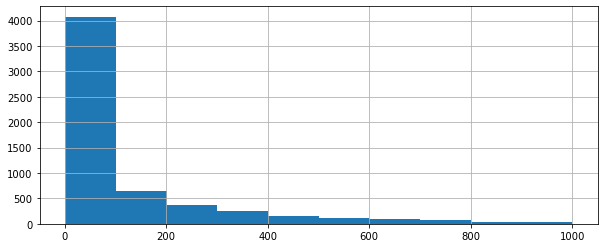

In [51]:
fig, ax = plt.subplots(figsize=(10,4))

data_set.loc[data_set['Длина, пог.м.'] < 1000, 'Длина, пог.м.'].hist()

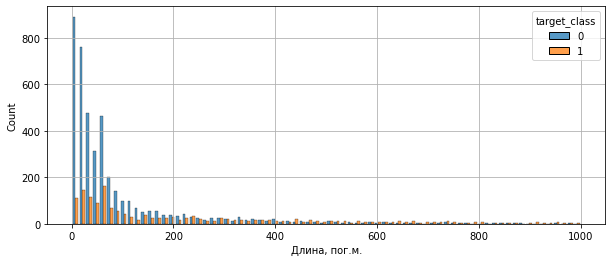

In [52]:
fig, ax = plt.subplots(figsize=(10,4))

ax = graf(data_set.loc[data_set['Длина, пог.м.'] < 1000], 'Длина, пог.м.', 'target_class')
ax.grid(True)

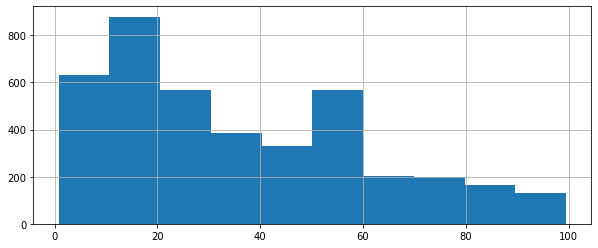

In [53]:
# 'Длина, пог.м.' поссмотрю распределение для <100
fig, ax = plt.subplots(figsize=(10,4))

ax = data_set.loc[data_set['Длина, пог.м.'] < 100, 'Длина, пог.м.'].hist()

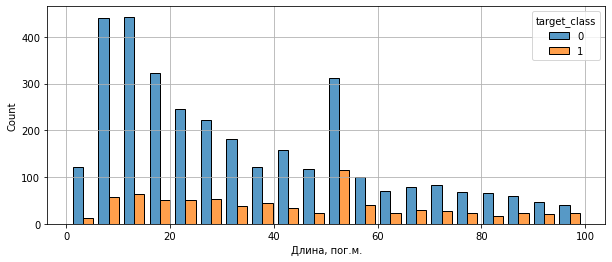

In [54]:
fig, ax = plt.subplots(figsize=(10,4))

ax = graf(data_set.loc[data_set['Длина, пог.м.'] < 100], 'Длина, пог.м.', 'target_class')
ax.grid(True)

In [55]:
#### 'Диаметр, мм.' поссмотрю распределение для <250

<AxesSubplot:>

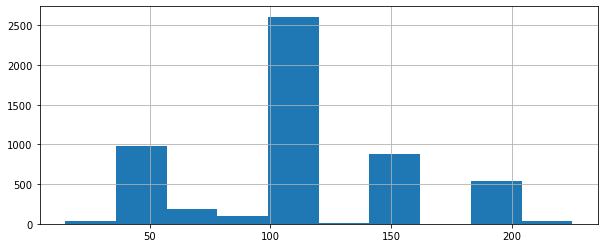

In [56]:
# 'Длина, пог.м.' поссмотрю распределение для <100
fig, ax = plt.subplots(figsize=(10,4))

data_set.loc[data_set['Диаметр, мм.'] < 250, 'Диаметр, мм.'].hist()

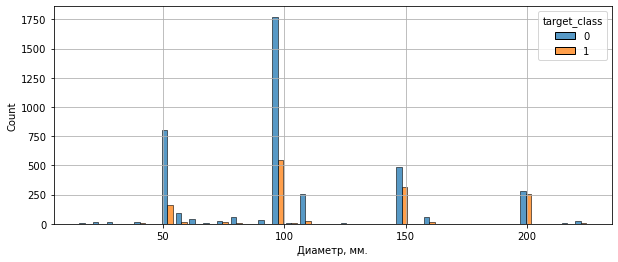

In [57]:
fig, ax = plt.subplots(figsize=(10,4))

ax = graf(data_set.loc[data_set['Диаметр, мм.'] < 250], 'Диаметр, мм.', 'target_class')
ax.grid(True)

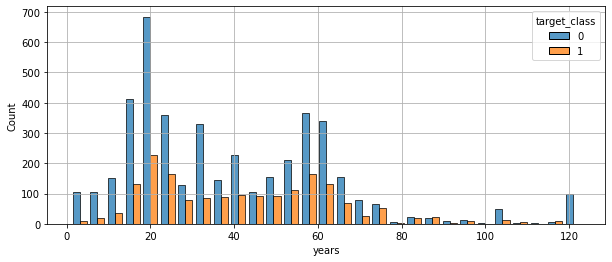

In [58]:
# распределение по годам
fig, ax = plt.subplots(figsize=(10,4))

ax = graf(data_set, 'years', 'target_class')
ax.grid(True)

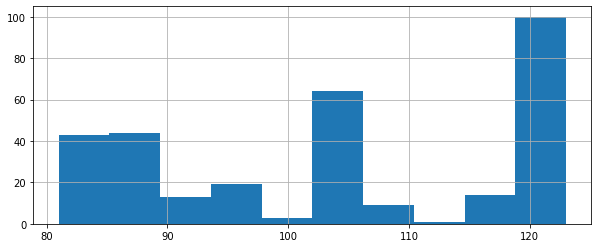

In [59]:
fig, ax = plt.subplots(figsize=(10,4))

ax = data_set.loc[data_set['years'] > 80, 'years'].hist() #-> заменить на медиа

In [60]:
data_set['years'].median()

35.0

In [61]:
data_set.loc[data_set['years'] > 80, 'years'] = data_set['years'].median()

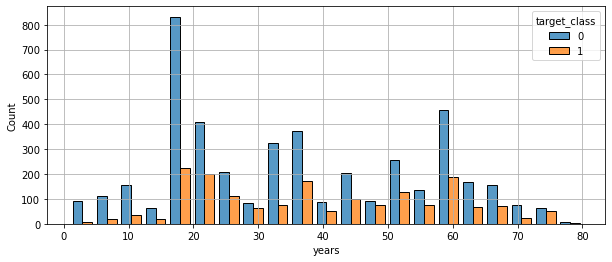

In [62]:
# распределение по годам
fig, ax = plt.subplots(figsize=(10,4))

ax = graf(data_set, 'years', 'target_class')
ax.grid(True)

#### Вывод рассмотрены распределния числовых признаков по target_class

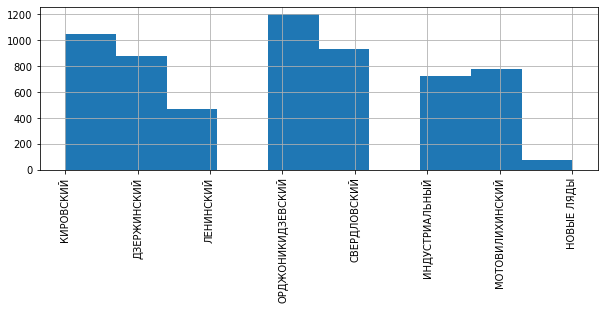

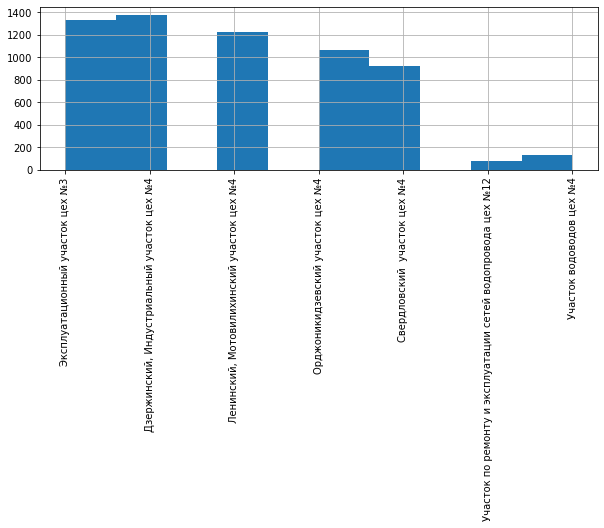

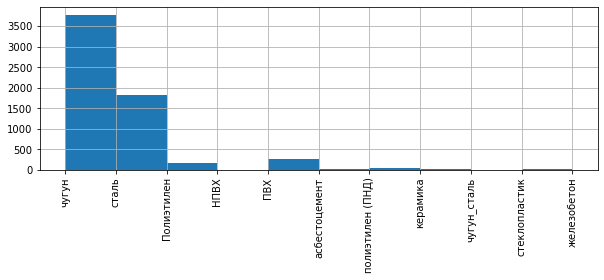

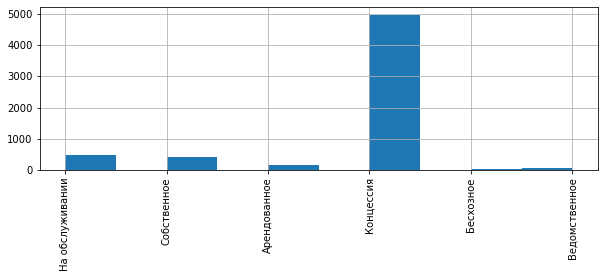

In [63]:
columns_temp = ['Наименование района','Наименование подразделения',
                'Наименование материала', 'Наименование принадлежности имущества']

for el in columns_temp:
    fig, ax = plt.subplots(figsize = (10,3))
    ax = data_set[el].hist()
    ax.tick_params(axis='x', labelrotation = 90)

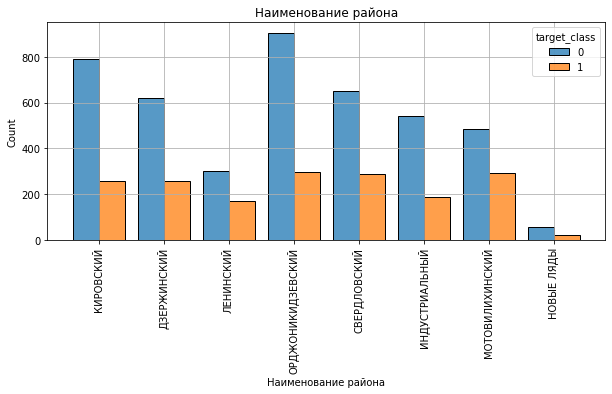

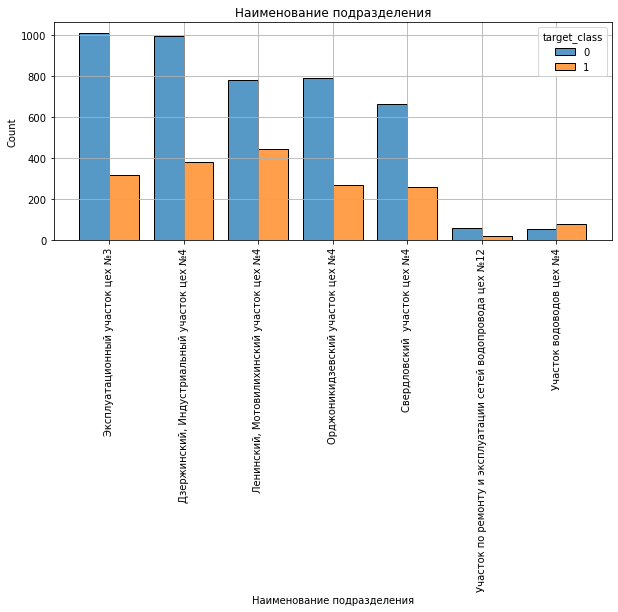

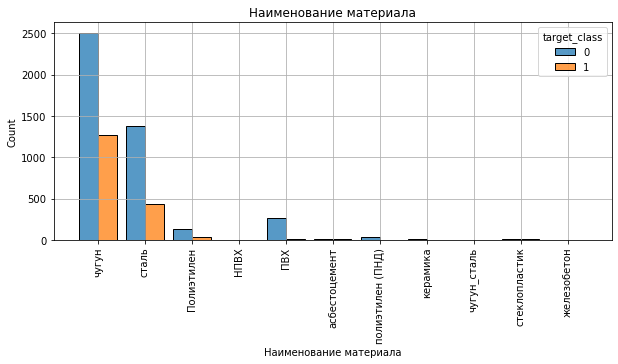

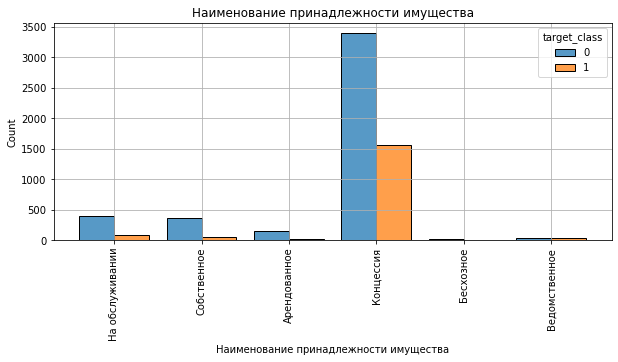

In [64]:
for column in columns_temp:
    # распределение по годам
    fig, ax = plt.subplots(figsize=(10,4))
    ax = graf(data_set, column, 'target_class')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(column)
    ax.grid(True)

#### Матрицы корреляций

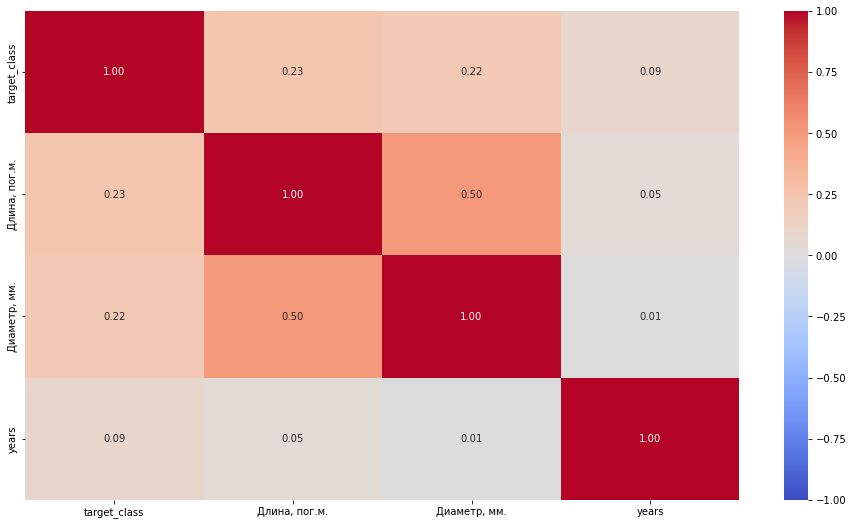

In [65]:
# Корреляции
# Ex.: https://github.com/smddyakonov/otus_ds_dyakonov/blob/main/hw-4/hw_4_smndyakonov.ipynb, 231 строка
data_set.corr() # - матрица корреляций [прямолинейная связь, y = kx +b]
plt.subplots(figsize=(16,9))
sns.heatmap(data_set.corr(), cmap=sns.color_palette("coolwarm", 10000), annot=True, fmt='.2f', vmin=-1, center=0)
plt.show()

interval columns not set, guessing: ['target_class', 'Длина, пог.м.', 'Диаметр, мм.', 'years']
interval columns not set, guessing: ['target_class', 'Длина, пог.м.', 'Диаметр, мм.', 'years']


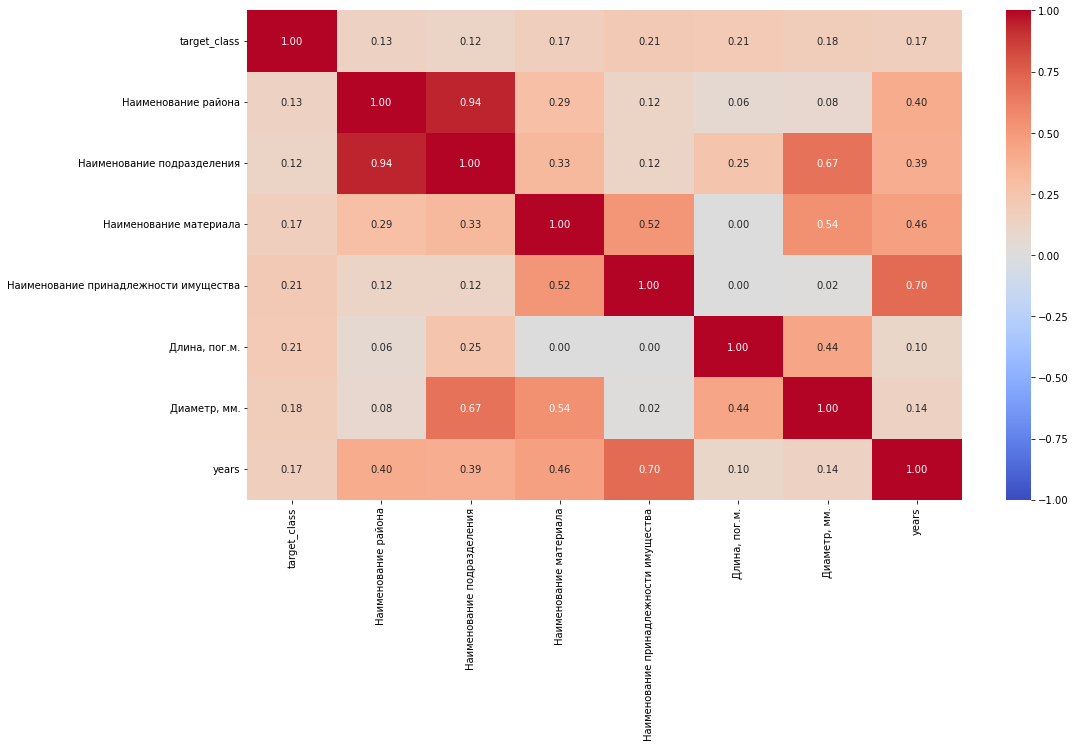

In [66]:
data_set.phik_matrix() # - матрица корреляций [прямолинейная связь, y = kx +b]
plt.subplots(figsize=(16,9))
sns.heatmap(data_set.phik_matrix(), cmap=sns.color_palette("coolwarm", 10000), annot=True, fmt='.2f', vmin=-1, center=0)
plt.show()

## Конструирование признаков

### Делаю data_set_learning
1. Выбор столбцов 
'target_class', 
'Наименование района',
'Наименование подразделения',
'years',
'Наименование материала',
'Наименование принадлежности имущества',
'Длина, пог.м.',
'Диаметр, мм.'
2. Проведу кодировку столбцов 'Наименование района' - OrdinalEncoder 'Наименование подразделения' - OrdinalEncoder 'Наименование материала' - частотный 'Наименование принадлежности имущества' - OrdinalEncoder

In [67]:
data_set_learning = data_set[['target_class', 
                             'Наименование района',
                             'Наименование подразделения',
                             'years',
                             'Наименование материала',
                             'Наименование принадлежности имущества',
                             'Длина, пог.м.',
                             'Диаметр, мм.']].copy()

In [68]:
data_set_learning

,target_class,Наименование района,Наименование подразделения,years,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм."
0,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,36.86,100.0
1,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,сталь,На обслуживании,755.00,200.0
2,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,202.80,200.0
3,0,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,198.40,200.0
4,0,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,сталь,На обслуживании,328.26,100.0
...,...,...,...,...,...,...,...,...
6112,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,40.22,100.0
6113,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,69.85,100.0
6114,1,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,372.42,100.0
6115,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,68,сталь,Концессия,777.00,200.0


In [69]:
label_encoder = LabelEncoder()

In [70]:
data_set_learning['district'] = label_encoder.fit_transform(data_set_learning['Наименование района'])
data_set_learning['user'] = label_encoder.fit_transform(data_set_learning['Наименование подразделения'])
data_set_learning['material'] = label_encoder.fit_transform(data_set_learning['Наименование материала'])
data_set_learning['belong'] = label_encoder.fit_transform(data_set_learning['Наименование принадлежности имущества'])

In [71]:
data_set_learning

,target_class,Наименование района,Наименование подразделения,years,Наименование материала,Наименование принадлежности имущества,"Длина, пог.м.","Диаметр, мм.",district,user,material,belong
0,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,36.86,100.0,2,6,9,4
1,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,сталь,На обслуживании,755.00,200.0,2,6,7,4
2,1,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,202.80,200.0,2,6,9,4
3,0,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,чугун,На обслуживании,198.40,200.0,2,6,9,4
4,0,КИРОВСКИЙ,Эксплуатационный участок цех №3,53,сталь,На обслуживании,328.26,100.0,2,6,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6112,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,40.22,100.0,7,3,9,3
6113,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,69.85,100.0,7,3,9,3
6114,1,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,58,чугун,Концессия,372.42,100.0,7,3,9,3
6115,0,СВЕРДЛОВСКИЙ,Свердловский участок цех №4,68,сталь,Концессия,777.00,200.0,7,3,7,3


In [72]:
data_set_learning = data_set_learning[['target_class', 
                                       'Длина, пог.м.', 
                                       'Диаметр, мм.', 
                                       'years', 
                                       'district', 
                                       'user', 
                                       'material', 
                                       'belong']]

In [73]:
data_set_learning

,target_class,"Длина, пог.м.","Диаметр, мм.",years,district,user,material,belong
0,1,36.86,100.0,53,2,6,9,4
1,1,755.00,200.0,53,2,6,7,4
2,1,202.80,200.0,53,2,6,9,4
3,0,198.40,200.0,53,2,6,9,4
4,0,328.26,100.0,53,2,6,7,4
...,...,...,...,...,...,...,...,...
6112,0,40.22,100.0,58,7,3,9,3
6113,0,69.85,100.0,58,7,3,9,3
6114,1,372.42,100.0,58,7,3,9,3
6115,0,777.00,200.0,68,7,3,7,3


## Моделирование

In [74]:
# метрики качества буду собирать в дата-фрейм df_metrics. Создам функцию

df_score = pd.DataFrame({"score":["Accuracy", "Precision", "Recall", "F1-score", "AUC"]})
df_score.set_index("score")

def get_df_score(classifier, y_expected, y_predicted, y_predicted_proba):
    accuracy = accuracy_score(y_predicted, y_expected)
    print("Accuracy:  {:.3f}".format(accuracy))

    precision = precision_score(y_predicted, y_expected)
    print("Precision: {:.3f}".format(precision))

    recall = recall_score(y_predicted, y_expected)
    print("Recall:    {:.3f}".format(recall))

    f1 = f1_score(y_predicted, y_expected)
    print("F1-score:  {:.3f}".format(f1))
    
    auc = roc_auc_score(y_expected, y_predicted_proba)
    print("AUC:       {:.3f}".format(auc))
    
    df_score[classifier] = [accuracy, precision, recall, f1, auc]

In [75]:
#Сохраним в  𝑋 все колонки признаки, а в  𝑦 − целевую переменную.
X = data_set_learning.drop('target_class', axis=1)
y = data_set_learning['target_class']

X.shape, y.shape

((6117, 7), (6117,))

In [76]:
X

,"Длина, пог.м.","Диаметр, мм.",years,district,user,material,belong
0,36.86,100.0,53,2,6,9,4
1,755.00,200.0,53,2,6,7,4
2,202.80,200.0,53,2,6,9,4
3,198.40,200.0,53,2,6,9,4
4,328.26,100.0,53,2,6,7,4
...,...,...,...,...,...,...,...
6112,40.22,100.0,58,7,3,9,3
6113,69.85,100.0,58,7,3,9,3
6114,372.42,100.0,58,7,3,9,3
6115,777.00,200.0,68,7,3,7,3


In [77]:
#Разобьем данные на тренировочный и тестовый наборы.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [78]:
scaler_list = ['Длина, пог.м.', 'Диаметр, мм.', 'years', 'district', 'user','material', 'belong'] 

In [79]:
#Приведу к одному масштабу непрерывные признаки
 
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = MinMaxScaler()
X_train_scaled[scaler_list] = scaler.fit_transform(X_train[scaler_list])
X_test_scaled[scaler_list] = scaler.transform(X_test[scaler_list])

In [80]:
X

,"Длина, пог.м.","Диаметр, мм.",years,district,user,material,belong
0,36.86,100.0,53,2,6,9,4
1,755.00,200.0,53,2,6,7,4
2,202.80,200.0,53,2,6,9,4
3,198.40,200.0,53,2,6,9,4
4,328.26,100.0,53,2,6,7,4
...,...,...,...,...,...,...,...
6112,40.22,100.0,58,7,3,9,3
6113,69.85,100.0,58,7,3,9,3
6114,372.42,100.0,58,7,3,9,3
6115,777.00,200.0,68,7,3,7,3


Посмотрим на соотношение классов в нашем датасете, для этого посчитаем количество нулей и единиц:

In [81]:
print(f"Labels: {set(y)}")
print(f"Zero count: {len(y)-sum(y)}, One count: {sum(y)}")

Labels: {0, 1}
Zero count: 4353, One count: 1764


Нулей в выборке 4353, а единиц 1764, это свидетельствует дисбаланса нет

### CatBoost

#### CatBoost из коробки

In [82]:
catboost_classifier_base = CatBoostClassifier()

catboost_classifier_base.fit(X_train_scaled, y_train, 
                              eval_set=(X_test_scaled, y_test),
                              verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [83]:
#CatBoost get_df_score
y_pred = catboost_classifier_base.predict(X_test_scaled)
y_pred_proba = catboost_classifier_base.predict_proba(X_test_scaled)
get_df_score('CatBoostClassifier_base', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.776
Precision: 0.426
Recall:    0.657
F1-score:  0.516
AUC:       0.782


#### Найду лучшие параметры на кросс-валидации

In [84]:
parameters = {
    'n_estimators': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.9),

    'depth': stats.randint(3, 13),
    "min_data_in_leaf": stats.randint(1, 10),    
    'l2_leaf_reg': stats.randint(1, 5),
    'random_strength': stats.uniform(0, 3),
    'bagging_temperature': stats.uniform(0.5, 1.0),
    'border_count': [32, 64, 128, 256]
}

catboost_classifier_tuned = RandomizedSearchCV(CatBoostClassifier(silent=True), parameters, 
                                               cv=5, n_jobs=-1)
catboost_classifier_tuned.fit(X_train_scaled, y_train)

print(catboost_classifier_tuned.score(X_train_scaled, y_train))
print(catboost_classifier_tuned.best_params_)

0.7748189675309507
{'bagging_temperature': 0.9018307468516794, 'border_count': 128, 'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.06490668608777676, 'min_data_in_leaf': 1, 'n_estimators': 114, 'random_strength': 0.594719083675863, 'subsample': 0.9821384253147367}


C:\Users\smndy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\smndy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\smndy\anaconda3\lib\site-packages\catboost\core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\smndy\anaconda3\lib\site-packages\catboost\core.py", line 2339, i

In [85]:
#CatBoost get_df_score
y_pred = catboost_classifier_tuned.predict(X_test_scaled)
y_pred_proba = catboost_classifier_tuned.predict_proba(X_test_scaled)
get_df_score('CatBoostClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.773
Precision: 0.416
Recall:    0.653
F1-score:  0.508
AUC:       0.779


посмотрю как модель обучается с лучшими параметрами

In [86]:
catboost_classifier_final = CatBoostClassifier(silent=True, 
                                               bagging_temperature = 0.8620600396341012, 
                                               border_count = 32,
                                               depth = 3, 
                                               l2_leaf_reg = 2, 
                                               learning_rate = 0.06231792887990922,
                                               min_data_in_leaf = 8,
                                               n_estimators = 221,
                                               random_strength = 2.3699029997837253,
                                               subsample = 0.6799237073536213)

catboost_classifier_final.fit(X_train_scaled, y_train, 
                              eval_set=(X_test_scaled, y_test),
                              verbose=False, plot=True)

print(catboost_classifier_final.score(X_train_scaled, y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7766876897921047


Применю n_estimators = 192 для теста

In [87]:
catboost_classifier_final = CatBoostClassifier(silent=True, 
                                               bagging_temperature = 0.8620600396341012, 
                                               border_count = 32,
                                               depth = 3, 
                                               l2_leaf_reg = 2, 
                                               learning_rate = 0.06231792887990922,
                                               min_data_in_leaf = 8,
                                               n_estimators = 192,
                                               random_strength = 2.3699029997837253,
                                               subsample = 0.6799237073536213)

catboost_classifier_final.fit(X_train_scaled, y_train, 
                              eval_set=(X_test_scaled, y_test),
                              verbose=False, plot=True)

print(catboost_classifier_final.score(X_train_scaled, y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.773183835552441


In [88]:
#CatBoost get_df_score
y_pred = catboost_classifier_final.predict(X_test_scaled)
y_pred_proba = catboost_classifier_final.predict_proba(X_test_scaled)
get_df_score('catboost_classifier_final', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.777
Precision: 0.416
Recall:    0.666
F1-score:  0.512
AUC:       0.777


### Моделирование. Вероятность

#### для прогнозирования возьму X и по столбцу years промоделирую 5 лет

In [89]:
df_pred_proba = pd.concat([y, X], axis = 1)

In [90]:
df_pred_proba.head(1)

,target_class,"Длина, пог.м.","Диаметр, мм.",years,district,user,material,belong
0,1,36.86,100.0,53,2,6,9,4


In [91]:
X_pred_proba = df_pred_proba.drop(columns = 'target_class')
y_before_prediction = df_pred_proba['target_class']

In [145]:
k = 0.8

### Моделирование. Вероятность  'years' + 1

In [146]:
X_pred_proba['years'] = X_pred_proba['years'] + 1

In [147]:
X_pred_proba

,"Длина, пог.м.","Диаметр, мм.",years,district,user,material,belong
0,36.86,100.0,69,2,6,9,4
1,755.00,200.0,69,2,6,7,4
2,202.80,200.0,69,2,6,9,4
3,198.40,200.0,69,2,6,9,4
4,328.26,100.0,69,2,6,7,4
...,...,...,...,...,...,...,...
6112,40.22,100.0,74,7,3,9,3
6113,69.85,100.0,74,7,3,9,3
6114,372.42,100.0,74,7,3,9,3
6115,777.00,200.0,84,7,3,7,3


In [148]:
X_pred_proba_scaled = X_pred_proba.copy()
X_pred_proba_scaled[scaler_list] = scaler.transform(X_pred_proba[scaler_list])

In [149]:
y_pred_proba = catboost_classifier_final.predict_proba(X_pred_proba_scaled)

In [150]:
y_pred_proba.shape

(6117, 2)

In [151]:
y_before_prediction

0       1
1       1
2       1
3       0
4       0
       ..
6112    0
6113    0
6114    1
6115    0
6116    0
Name: target_class, Length: 6117, dtype: int64

In [152]:
df_pred_proba = pd.DataFrame(y_pred_proba)

In [153]:
df_seti.columns

Index(['Unnamed: 0', 'Код ', 'Инвентарный номер', 'Наименование',
       'Наименование вида объекта', 'Наименование района',
       'Наименование подразделения', 'Дата ввода в эксплуатацию',
       'Наименование материала', 'Наименование принадлежности имущества',
       'Длина, пог.м.', 'Диаметр, мм.'],
      dtype='object')

In [154]:
df_seti[['Код ']]

,Код
0,03200_102_б/х
1,03200_100_б/х
2,03200_98_б/х
3,03200_96_б/х
4,03200_95_б/х
...,...
6112,000612_к
6113,000611_к
6114,000608_к
6115,02436_к


In [155]:
df_y_before_prediction = pd.DataFrame(y_before_prediction)

In [156]:
df_y_before_prediction

,target_class
0,1
1,1
2,1
3,0
4,0
...,...
6112,0
6113,0
6114,1
6115,0


In [157]:
df_pred_proba = pd.concat([df_seti[['Код ', 'Наименование']], df_y_before_prediction, df_pred_proba], axis = 1)

In [158]:
df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)].shape

(6, 5)

In [159]:
df_pred_proba_1 = df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)]

### Моделирование. Вероятность  'years' +2

In [160]:
X_pred_proba['years'] = X_pred_proba['years'] + 2

In [161]:
X_pred_proba_scaled = X_pred_proba.copy()
X_pred_proba_scaled[scaler_list] = scaler.transform(X_pred_proba[scaler_list])

In [162]:
y_pred_proba = catboost_classifier_final.predict_proba(X_pred_proba_scaled)

In [163]:
df_pred_proba = pd.DataFrame(y_pred_proba)

In [164]:
df_y_before_prediction = pd.DataFrame(y_before_prediction)

In [165]:
df_pred_proba = pd.concat([df_seti[['Код ', 'Наименование']], df_y_before_prediction, df_pred_proba], axis = 1)

In [166]:
df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)].shape

(7, 5)

In [167]:
df_pred_proba_2 = df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)]

### Моделирование. Вероятность  'years' + 3

In [168]:
X_pred_proba['years'] = X_pred_proba['years'] + 3

In [169]:
X_pred_proba_scaled = X_pred_proba.copy()
X_pred_proba_scaled[scaler_list] = scaler.transform(X_pred_proba[scaler_list])

In [170]:
y_pred_proba = catboost_classifier_final.predict_proba(X_pred_proba_scaled)

In [171]:
df_pred_proba = pd.DataFrame(y_pred_proba)

In [172]:
df_y_before_prediction = pd.DataFrame(y_before_prediction)

In [173]:
df_pred_proba = pd.concat([df_seti[['Код ', 'Наименование']], df_y_before_prediction, df_pred_proba], axis = 1)

In [174]:
df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)].shape

(7, 5)

In [175]:
df_pred_proba_3 = df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)]

### Моделирование. Вероятность  'years' + 4

In [176]:
X_pred_proba['years'] = X_pred_proba['years'] + 4

In [177]:
X_pred_proba_scaled = X_pred_proba.copy()
X_pred_proba_scaled[scaler_list] = scaler.transform(X_pred_proba[scaler_list])

In [178]:
y_pred_proba = catboost_classifier_final.predict_proba(X_pred_proba_scaled)

In [179]:
df_pred_proba = pd.DataFrame(y_pred_proba)

In [180]:
df_y_before_prediction = pd.DataFrame(y_before_prediction)

In [181]:
df_pred_proba = pd.concat([df_seti[['Код ', 'Наименование']], df_y_before_prediction, df_pred_proba], axis = 1)

In [182]:
df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)].shape

(5, 5)

In [183]:
df_pred_proba_4 = df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)]

### Моделирование. Вероятность  'years' + 5

In [184]:
X_pred_proba['years'] = X_pred_proba['years'] + 5

In [185]:
X_pred_proba_scaled = X_pred_proba.copy()
X_pred_proba_scaled[scaler_list] = scaler.transform(X_pred_proba[scaler_list])

In [186]:
y_pred_proba = catboost_classifier_final.predict_proba(X_pred_proba_scaled)

In [187]:
df_pred_proba = pd.DataFrame(y_pred_proba)

In [188]:
df_y_before_prediction = pd.DataFrame(y_before_prediction)

In [189]:
df_pred_proba = pd.concat([df_seti[['Код ', 'Наименование']], df_y_before_prediction, df_pred_proba], axis = 1)

In [190]:
df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)].shape

(5, 5)

In [191]:
df_pred_proba_5 = df_pred_proba.loc[(df_pred_proba[1] > k) & (df_pred_proba['target_class'] == 0)]

### Моделирование. Вероятность итоговая таблица

In [192]:
df_pred_proba_1_5 = (pd.concat([df_pred_proba_1, df_pred_proba_2, df_pred_proba_3, df_pred_proba_4, df_pred_proba_5], axis = 0)
                     .drop_duplicates())
df_pred_proba_1_5 = df_pred_proba_1_5[['Код ', 'Наименование', 1]]

In [193]:
df_pred_proba_1_5.rename(columns = {1: 'вероятность наступления целевого случая'}, inplace = True)

In [194]:
df_pred_proba_1_5.to_excel('вероятность наступления целевого случая.xlsx')

# Вывод:
    1. Проведен EDA
    2. Cконструированы признаки
    3. Посчитана модель
    4. Сформирован перечень сетей для планирования

In [195]:
df_pred_proba_1_5[['Код ', 'вероятность наступления целевого случая']]

,Код,вероятность наступления целевого случая
3435,3189ч_к,0.812772
3766,687ч_к,0.805148
4039,3952с_к,0.806813
4075,1060ч_к,0.814789
4107,3664с_к,0.809063
...,...,...
1090,471553_к,0.805100
2234,4187ч_к,0.802453
3919,4942ч_к,0.801147
5432,4603ч_к,0.811650


In [196]:
df_pred_proba_1_5.shape

(27, 3)